In [ ]:
!pip install -U scikit-learn

### Выполнил студент МИВ-221: Айвар Уркунов

# Часть 1. Линейная регрессия

Датасет: https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset \

Для приведенного выше датасета, построить модель линейной регрессии для оценивания стоимости аренды недвижимости. \
Для решения задачи предлагается использовать следующие подходы:
1. Получить решение задачи в замкнутом виде с помощью псевдообратной матрицы. Рассмотреть случаи без регуляризации и с 𝐿2 регуляризацией.
2. Получить решение задачи методом градиентного спуска. Получить формулу для градиента, используя матрицу признаков. Сравнить полученные решение с п.1.

При решении задачи необходимо ответить на следующие вопросы:

1. Какие признаки оказывают наибольший вклад в точность определения
стоимости аренды? Предложить способы отбора наиболее важных признаков
2. Какая модель имеет наименьшее значение функции потерь на тестовой
выборке? Помогает ли регуляризация избежать эффекта переобучения в данном примере?

## Dataset Glossary.txt

- BHK: Number of Bedrooms, Hall, Kitchen.

- Rent: Rent of the Houses/Apartments/Flats.

- Size: Size of the Houses/Apartments/Flats in Square Feet.

- Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)

- Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.

- Area Locality: Locality of the Houses/Apartments/Flats.

- City: City where the Houses/Apartments/Flats are Located.

- Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

- Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.

- Bathroom: Number of Bathrooms.

- Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.

In [81]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, pinv, norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor

In [82]:
# загрузим датасет и выделим фичи и таргет
# загрузил датасет в директорию, в которой находится Python-ноутбук

df = pd.read_csv('House_Rent_Dataset.csv')

X = df.drop('Rent', axis=1)
y = df['Rent']

print(X.columns.tolist())
X.head()

['Posted On', 'BHK', 'Size', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']


,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [83]:
# немного поресерчим загруженный датасет

In [84]:
X.describe()

,BHK,Size,Bathroom
count,4746.000000,4746.000000,4746.000000
mean,2.083860,967.490729,1.965866
std,0.832256,634.202328,0.884532
min,1.000000,10.000000,1.000000
25%,2.000000,550.000000,1.000000
50%,2.000000,850.000000,2.000000
75%,3.000000,1200.000000,2.000000
max,6.000000,8000.000000,10.000000


In [85]:
X.nunique().sort_values(ascending=False)

Area Locality        2235
Size                  615
Floor                 480
Posted On              81
Bathroom                8
BHK                     6
City                    6
Area Type               3
Furnishing Status       3
Tenant Preferred        3
Point of Contact        3
dtype: int64

### 4 первые переменные имеют относительно большое кол-во уникальных значений, но Size является числовой переменной, возможно придется убирать из модели переменные Area Locality, Floor и Posted On. Возможно нужно будет как-то преобразовать или убрать признак Posted On, тк это переменная в формате даты.

In [86]:
# разделим категориальные и числовые переменные

categorical_cols = [cname for cname in X.columns if
                    X[cname].dtype == "object"]

numerical_cols = [cname for cname in X.columns if 
                  X[cname].dtype in ['int64', 'float64']]

print(categorical_cols, numerical_cols, sep='\n')

df[categorical_cols].nunique().sort_values(ascending=False)

['Posted On', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
['BHK', 'Size', 'Bathroom']


Area Locality        2235
Floor                 480
Posted On              81
City                    6
Area Type               3
Furnishing Status       3
Tenant Preferred        3
Point of Contact        3
dtype: int64

In [87]:
# Обработаем числовые и категориальные признаки

In [88]:
numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [89]:
# определим модель линейной регрессии

In [90]:
model = LinearRegression()

In [91]:
# объединим обработку данных и определение модели в один пайплайн

In [92]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [93]:
# разделим на обучающую и тестовую выборку в отношении 0.8/0.2

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [111]:
# обучим модель и спрогнозируем значения целевой переменной

In [96]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [97]:
# RMSE

In [98]:
score = mean_squared_error(y_test, preds, squared=False)
score

123041.08848601085

## Решение задачи в замкнутом виде

Решение в Замкнутом Виде:
- Без Регуляризации: Решение θ = (XᵀX)⁻¹Xᵀy, где X — матрица признаков, y — вектор целевых значений.
- С L2 Регуляризацией: Решение θ = (XᵀX + λI)⁻¹Xᵀy, где λ — коэффициент регуляризации, I — единичная матрица.

In [ ]:
target = 'Rent'

In [32]:
def solution_in_closed_form(df, X, y, numerical_cols, target):
    X = df[numerical_cols].to_numpy()
    y = df[target].to_numpy()
    m, n = X.shape

    # добавление единицы к признакам для учета смещения
    X_b = np.c_[np.ones((m, 1)), X]

    # без регуляризации
    theta_best = pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    # с L2 регуляризацией
    lambda_reg = 1
    theta_best_reg = pinv(X_b.T.dot(X_b) + lambda_reg * np.eye(n + 1)).dot(X_b.T).dot(y)

    return theta_best, theta_best_reg

In [46]:
solution_in_closed_form_parameters = solution_in_closed_form(df, X, y, numerical_cols, target)
print(f"Параметры модели без регуляризации: {solution_in_closed_form_parameters[0]}"
     , f"Параметры модели с L2 регуляризацией: {solution_in_closed_form_parameters[1]}"
     , sep = '\n')

Параметры модели без регуляризации: [-3.87930445e+04 -1.54691474e+03  2.42409133e+01  2.72435614e+04]
Параметры модели с L2 регуляризацией: [-3.87237370e+04 -1.55452023e+03  2.42639453e+01  2.72091833e+04]


## Метод градиентного спуска

Метод градиентного спуска:
- Определение функции стоимости, например, MSE.
- Получение формулы для градиента: ∇ₜₕₑₜₐMSE(θ) = (2/m) Xᵀ(Xθ - y), где m — количество образцов.
- Обновление весов θ на каждом шаге с использованием скорости обучения.

In [41]:
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1 / (2 * m)) * np.sum(np.square(predictions - y))
    return cost

def gradient_descent(X, y, theta, learning_rate, num_iterations):
    m = len(y)
    cost_history = np.zeros(num_iterations)

    for i in range(num_iterations):
        gradients = 2/m * X.T.dot(X.dot(theta) - y)
        theta = theta - learning_rate * gradients
        cost_history[i] = compute_cost(X, y, theta)

    return theta, cost_history

def gradient_descent_method(df, X, y, numerical_cols, target):
    X = df[numerical_cols].to_numpy()
    y = df[target].to_numpy()
    m, n = X.shape
    
    # масштабирую признаки
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # обавление единицы к масштабированным признакам для учета смещения
    X_scaled_b = np.c_[np.ones((m, 1)), X_scaled]

    # параметры градиентного спуска
    theta = np.zeros(n + 1)
    learning_rate = 0.01
    num_iterations = 1000
    
    theta_gd, cost_history = gradient_descent(X_scaled_b, y, theta, learning_rate, num_iterations)
    return theta_gd, cost_history[-1]

In [47]:
gradient_descent_method_parameters = gradient_descent_method(df, X, y, numerical_cols, target)
print(f"Параметры модели методом градиентного спуска: {gradient_descent_method_parameters[0]}"
     , f"Значении функции стоимости: {gradient_descent_method_parameters[1]}"
     , sep = '\n')

Параметры модели методом градиентного спуска: [34993.45126854 -1091.57300411 15396.88047583 23877.56106276]
Значении функции стоимости: 2404878866.108573


## Сравнение решений

In [48]:
print(f"Параметры модели без регуляризации: {solution_in_closed_form_parameters[0]}"
     , f"Параметры модели с L2 регуляризацией: {solution_in_closed_form_parameters[1]}"
     , f"Параметры модели методом градиентного спуска: {gradient_descent_method_parameters[0]}"
     , sep = '\n')

Параметры модели без регуляризации: [-3.87930445e+04 -1.54691474e+03  2.42409133e+01  2.72435614e+04]
Параметры модели с L2 регуляризацией: [-3.87237370e+04 -1.55452023e+03  2.42639453e+01  2.72091833e+04]
Параметры модели методом градиентного спуска: [34993.45126854 -1091.57300411 15396.88047583 23877.56106276]
Значении функции стоимости: 2404878866.108573


# Вопросы:

### 1) Какие признаки оказывают наибольший вклад в точность определения стоимости аренды? Предложить способы отбора наиболее важных признаков

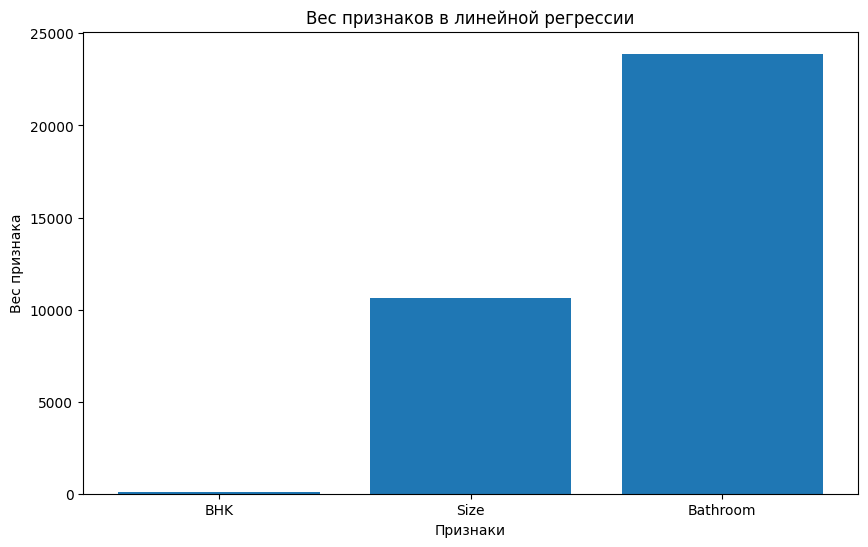

In [65]:
import matplotlib.pyplot as plt

coefficients = lr.coef_[1:]

plt.figure(figsize=(10, 6))
plt.bar(numerical_cols, np.abs(coefficients))
plt.xlabel('Признаки')
plt.ylabel('Вес признака')
plt.title('Вес признаков в линейной регрессии')
# plt.xticks(rotation=45)
plt.show()

Наиболее важным из числовых признаков является Bathroom - кол-во ванных комнат

Существует несколько методов отбора признаков:
- Обертывающие методы (Wrapper methods): Используют конкретный алгоритм машинного обучения и оценивают комбинации признаков, например, рекурсивное устранение признаков (RFE).
- Фильтрационные методы (Filter methods): Оценивают значимость признаков на основе статистических тестов, например, корреляции.
- Встраиваемые методы (Embedded methods): Интегрируют отбор признаков в процесс обучения, например, Lasso регрессия, которая использует L1 регуляризацию.

### 2) Какая модель имеет наименьшее значение функции потерь на тестовой выборке? Помогает ли регуляризация избежать эффекта переобучения в данном примере?

In [57]:
X = df[numerical_cols].to_numpy()
y = df[target].to_numpy()
m, n = X.shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# добавление столбца с единицами для учета смещения
X_train_scaled_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_scaled_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

# обучение модели без регуляризации
lr = LinearRegression()
lr.fit(X_train_scaled_b, y_train)
y_pred_lr = lr.predict(X_test_scaled_b)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# обучение модели с L2 регуляризацией (Ridge)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled_b, y_train)
y_pred_ridge = ridge.predict(X_test_scaled_b)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

# обучение модели с помощью стохастического градиентного спуска
sgd_reg = SGDRegressor(max_iter=1000, tol=0.001, penalty=None, eta0=0.1, random_state=0)
sgd_reg.fit(X_train_scaled, y_train.ravel())
y_pred_sgd = sgd_reg.predict(X_test_scaled)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

np.sqrt(mse_lr), np.sqrt(mse_ridge), np.sqrt(mse_sgd)

(126175.17374792077, 126175.71691151026, 125664.6064539341)

В данном случае регуляризация не оказывает значительного влияния на уменьшение переобучения, тк все три модели показывают схожую производительность на тестовой выборке.